/Users/platypus/miniconda3/envs/venv_bcn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Plotting for model openl3
and saving them into figures/2d_plots/openl3


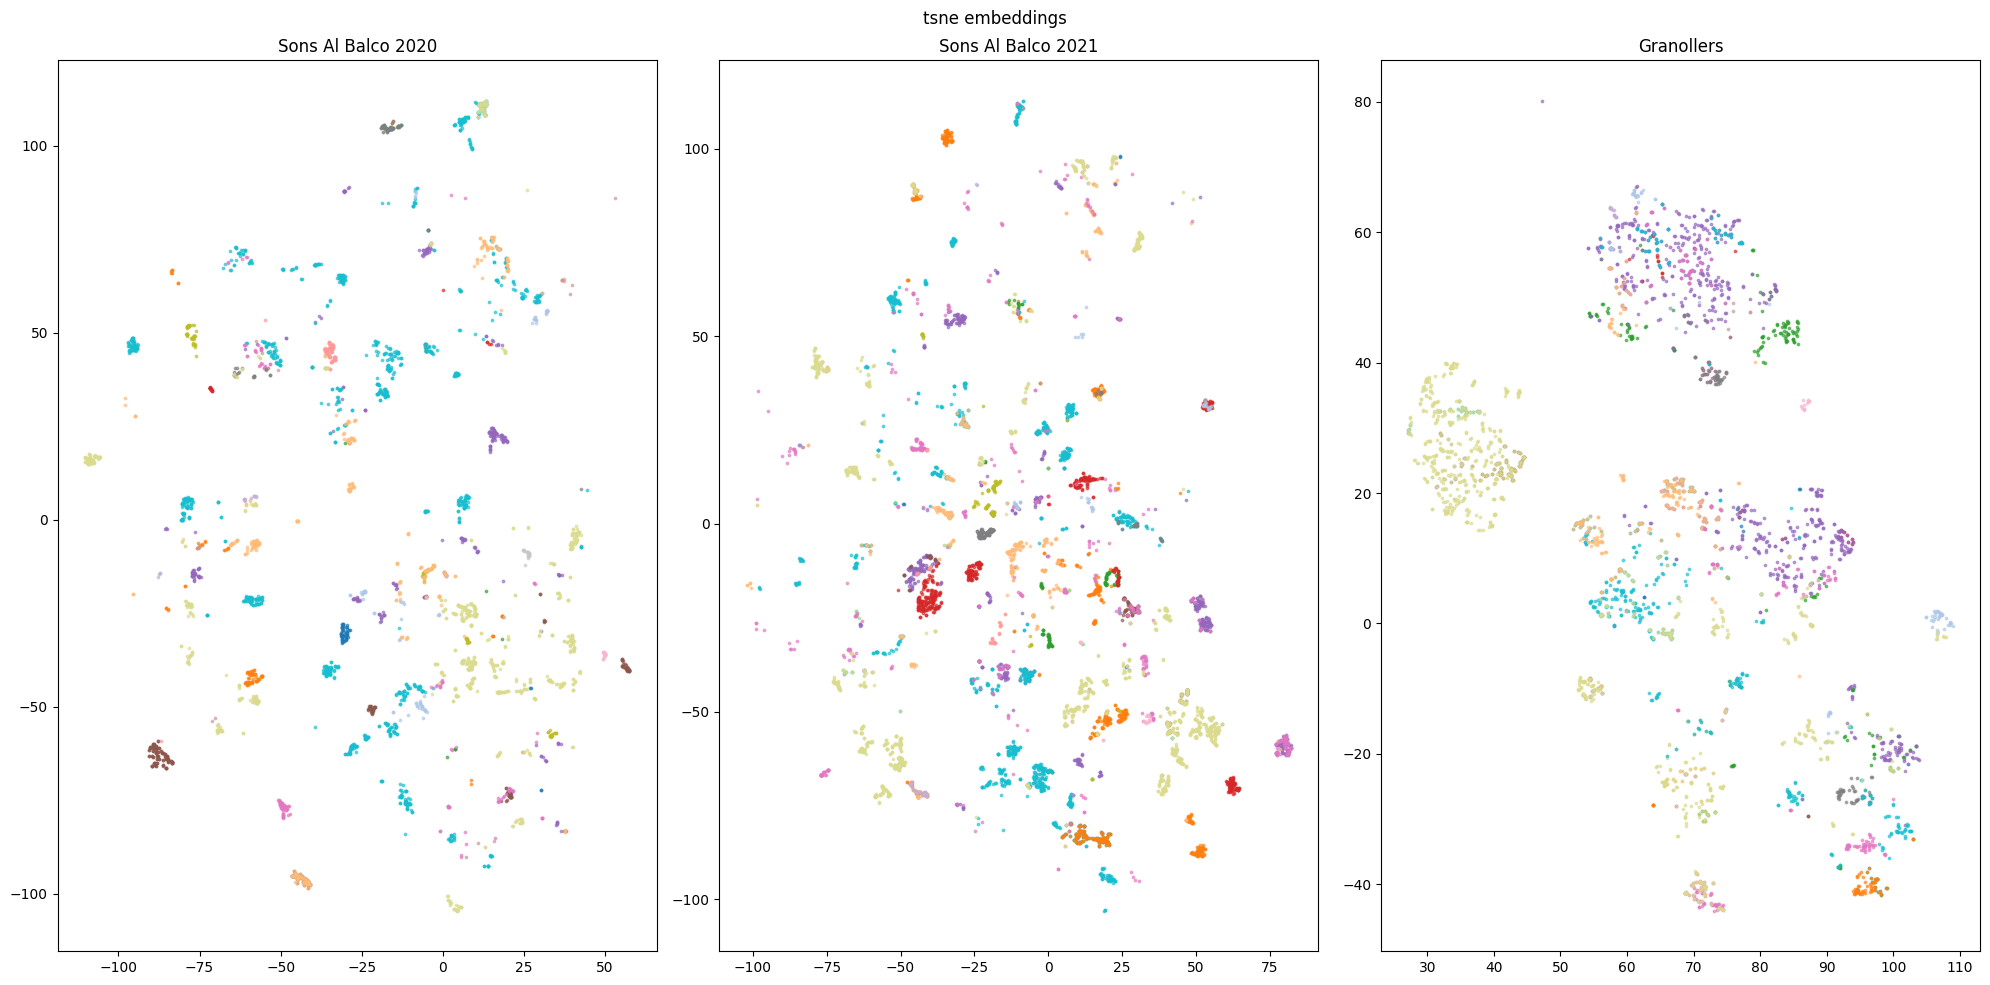

In [1]:
import os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from utils import load_embeddings, load_labels, compute_all_labels, aggregate_embeddings, aggregate_labels

# Number of colors
num_colors = 40

# List of qualitative colormaps
cmaps = [
    "tab10",
    "tab20",
    "Set3",
    "Set2",
    "Set1",
    "Pastel1",
    "Pastel2",
    "Dark2",
    "Accent",
]

# Generate colors
colors = []
for cmap_name in cmaps:
    cmap = mpl.colormaps.get_cmap(cmap_name)
    colors.extend(cmap(np.arange(cmap.N)))

# If we have more colors than needed, truncate the list
if len(colors) > num_colors:
    colors = colors[:num_colors]


def plot_overall_embeddings(
    data,
    labels,
    idxs,
    datasets,
    all_labels,
    model,
    image_folder,
    size: int = 3,
    alpha: float = 0.6,
    filename: str = "all_datasets",
):
    n_col = len(datasets) // 3 + len(datasets) % 3
    _, axs = plt.subplots(n_col, 3, figsize=(20, 10))
    axs = axs.flatten()

    for i, dataset in enumerate(datasets):
        start, end = idxs[dataset]
        data_subset = data[start:end]
        lab_list_subset = labels[start:end]

        # select points with at least one label
        # idx = [l_i for l_i, l in enumerate(lab_list_subset) if len(l) > 0]
        # data_subset = data_subset[idx]
        # lab_list_subset = [lab_list_subset[k] for k in idx]

        for j, lab in enumerate(all_labels):
            lab_idx = [l_i for l_i, l in enumerate(lab_list_subset) if lab in l]
            if len(lab_idx) == 0:
                continue
            axs[i].scatter(
                x=data_subset[lab_idx, 0],
                y=data_subset[lab_idx, 1],
                label=lab,
                color=colors[j],
                s=size,
                alpha=alpha,
            )
        axs[i].set_title(dataset.replace("_", " ").title())

    plt.suptitle(f"{model} embeddings")
    # plt.legend()
    plt.tight_layout()
    model_folder = os.path.join(image_folder, model)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    #plt.savefig(os.path.join(model_folder, f"{filename}.png"), dpi=300)
    #plt.close()
    plt.show()


def plot_labels_embeddings(
    data,
    labels,
    idxs,
    datasets,
    all_labels,
    model,
    image_folder,
    size: int = 8,
    alpha: float = 0.6,
):

    for lab in all_labels:
        plt.figure(figsize=(15, 15))

        for i, dataset in enumerate(datasets):
            start, end = idxs[dataset]
            data_subset = data[start:end]
            lab_list_subset = labels[start:end]

            # select points with at least one label
            idx = [j for j, l in enumerate(lab_list_subset) if lab in l]
            data_subset = data_subset[idx]
            plt.scatter(
                x=data_subset[:, 0],
                y=data_subset[:, 1],
                label=dataset.replace("_", " ").title(),
                color=colors[i],
                s=size,
                alpha=alpha,
            )

        plt.title(f"{model} {lab} embeddings")
        plt.legend()
        model_folder = os.path.join(image_folder, model)
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        filename = f"{lab}.png".replace("/", "_")
        plt.savefig(os.path.join(model_folder, filename), dpi=300)
        plt.close()


IMAGE_FOLDER = "figures/2d_plots"
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)

DATA_FOLDER: str = "data"
EMB_FOLDER: str = "data/embeddings"

loaded_embeddings = load_embeddings(EMB_FOLDER)
labels = load_labels(DATA_FOLDER)
all_labels = compute_all_labels(labels)

models = loaded_embeddings.keys()
datasets = labels.keys()

# let's modify embeddings to be {model: {dataset: np.array (total_frames, features)}}
# and labels to be {dataset: [list (tot n frames) of lists (labels in frame)]}
loaded_embeddings = aggregate_embeddings(loaded_embeddings)
labels = aggregate_labels(labels)

for model in models:
    image_folder = os.path.join(IMAGE_FOLDER, model)
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)

    print(f"Plotting for model {model}")
    print(f"and saving them into {image_folder}")
    
    # we want a single array for every emb of the model (i.e., for each dataset)
    # and a list of list of labels, w same length as emb.shape[0].
    # Also, to do the plots, we need a dict {dataset: (start_idx, end_idx)}.
    # We will compute it while concatenating the embeddings
    idxs = {}
    start, end = 0, 0
    model_emb = []
    for dataset in datasets:
        e = loaded_embeddings[model][dataset]
        end += e.shape[0]
        idxs[dataset] = (start, end)
        start = end

        model_emb.append(e)
    model_emb = np.concatenate(model_emb)

    model_labels = []
    for dataset in datasets:
        model_labels.extend(labels[dataset])

    pca = PCA(n_components=50)
    pca_data = pca.fit_transform(model_emb)
    # compute tsne
    BEST_PERPL = 30
    BEST_EARLY_EX = 12
    tsne = TSNE(n_components=2, perplexity=BEST_PERPL, early_exaggeration=BEST_EARLY_EX)
    tsne_data = tsne.fit_transform(pca_data)
    # compute umap
    BEST_N_NEIGH = 15
    BEST_MIN_DIST = 0.1
    # umap = umap.UMAP(n_neighbors=BEST_N_NEIGH, min_dist=BEST_MIN_DIST)
    # umap_data = umap.fit_transform(pca_data)

    # we can plot
    plot_overall_embeddings(
        tsne_data, model_labels, idxs, datasets, all_labels, "tsne", image_folder
    )
    # plot_overall_embeddings(umap_data, model_labels, idxs, datasets, all_labels, "umap")

    break

    # plot first level of the taxonomy
    first_levels = tuple(set([l.split("/")[0] for l in all_labels]))
    plot_overall_embeddings(
        tsne_data,
        model_labels,
        idxs,
        datasets,
        first_levels,
        "tsne",
        image_folder,
        size=8,
        filename="all_datasets_first",
    )
    # plot_overall_embeddings(umap_data, model_labels, idxs, datasets, first_levels, "umap")

    plot_labels_embeddings(
        tsne_data, model_labels, idxs, datasets, all_labels, "tsne", image_folder
    )
    # plot_labels_embeddings(umap_data, model_labels, idxs, datasets, all_labels, "umap")


In [2]:
all_labels

['Human/Cough',
 'Human/Movement',
 'Human/Movement/Steps',
 'Human/Music',
 'Human/Voice',
 'Industrial/Construction',
 'Industrial/Industry',
 'Industrial/Vacuum',
 'Industrial/Ventilation',
 'Nature/Animals/Bird',
 'Nature/Animals/Cat',
 'Nature/Animals/Dog',
 'Nature/Elements/Water',
 'Nature/Elements/Wind',
 'Nature/Vegetation',
 'Signals',
 'Signals/Alarm',
 'Signals/Bells',
 'Signals/Klaxon',
 'Signals/Siren',
 'Things/Blind',
 'Things/Door',
 'Things/Movement',
 'Things/Trolley',
 'Transport/Motorized',
 'Transport/Motorized/Air',
 'Transport/Motorized/Rail',
 'Transport/Motorized/Road',
 'Transport/Non-motorized']

In [22]:
# List of qualitative colormaps
cmaps = [
    "tab10",
    "tab20",
    "Set3",
    "Set2",
    "Set1",
    "Pastel1",
    "Pastel2",
    "Dark2",
    "Accent",
]

# Generate colors
colors = []
for cmap_name in cmaps:
    cmap = mpl.colormaps.get_cmap(cmap_name)
    colors.extend(cmap(np.arange(cmap.N)))

# If we have more colors than needed, truncate the list
if len(colors) > num_colors:
    colors = colors[:num_colors]

def plot_overall_embeddings(
    data,
    labels,
    idxs,
    datasets,
    all_labels,
    model,
    image_folder,
    size: int = 3,
    alpha: float = 0.3,
    filename: str = "all_datasets",
):
    n_col = len(datasets) // 3 + len(datasets) % 3
    _, axs = plt.subplots(n_col, 3, figsize=(15, 8), dpi=300)
    axs = axs.flatten()

    for i, dataset in enumerate(datasets):
        start, end = idxs[dataset]
        data_subset = data[start:end]
        lab_list_subset = labels[start:end]

        # select points with at least one label
        # idx = [l_i for l_i, l in enumerate(lab_list_subset) if len(l) > 0]
        # data_subset = data_subset[idx]
        # lab_list_subset = [lab_list_subset[k] for k in idx]

        for j, lab in enumerate(all_labels):
            lab_idx = [l_i for l_i, l in enumerate(lab_list_subset) if lab in l]
            if len(lab_idx) == 0:
                continue
            axs[i].scatter(
                x=data_subset[lab_idx, 0],
                y=data_subset[lab_idx, 1],
                label=lab,
                color=colors[j],
                s=size,
                alpha=alpha,
            )
        axs[i].set_title(dataset.replace("_", " ").title(), fontsize=20, pad=15)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    handles, labels = plt.gca().get_legend_handles_labels()
    lgnd = _.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.10), ncol=6, markerscale=5)
    for handle in lgnd.legendHandles:
        handle.set_alpha(1)
    #plt.suptitle(f"{model} embeddings")
    # plt.legend()
    plt.tight_layout()
    model_folder = os.path.join(image_folder, model)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    #plt.savefig(os.path.join(model_folder, f"{filename}.png"), dpi=300)
    #plt.close()
    plt.show()

In [ ]:
import matplotlib.patches as mpatches
for j, lab in enumerate(all_labels):
    j_patch = mpatches.Patch(color='red', label='Female')


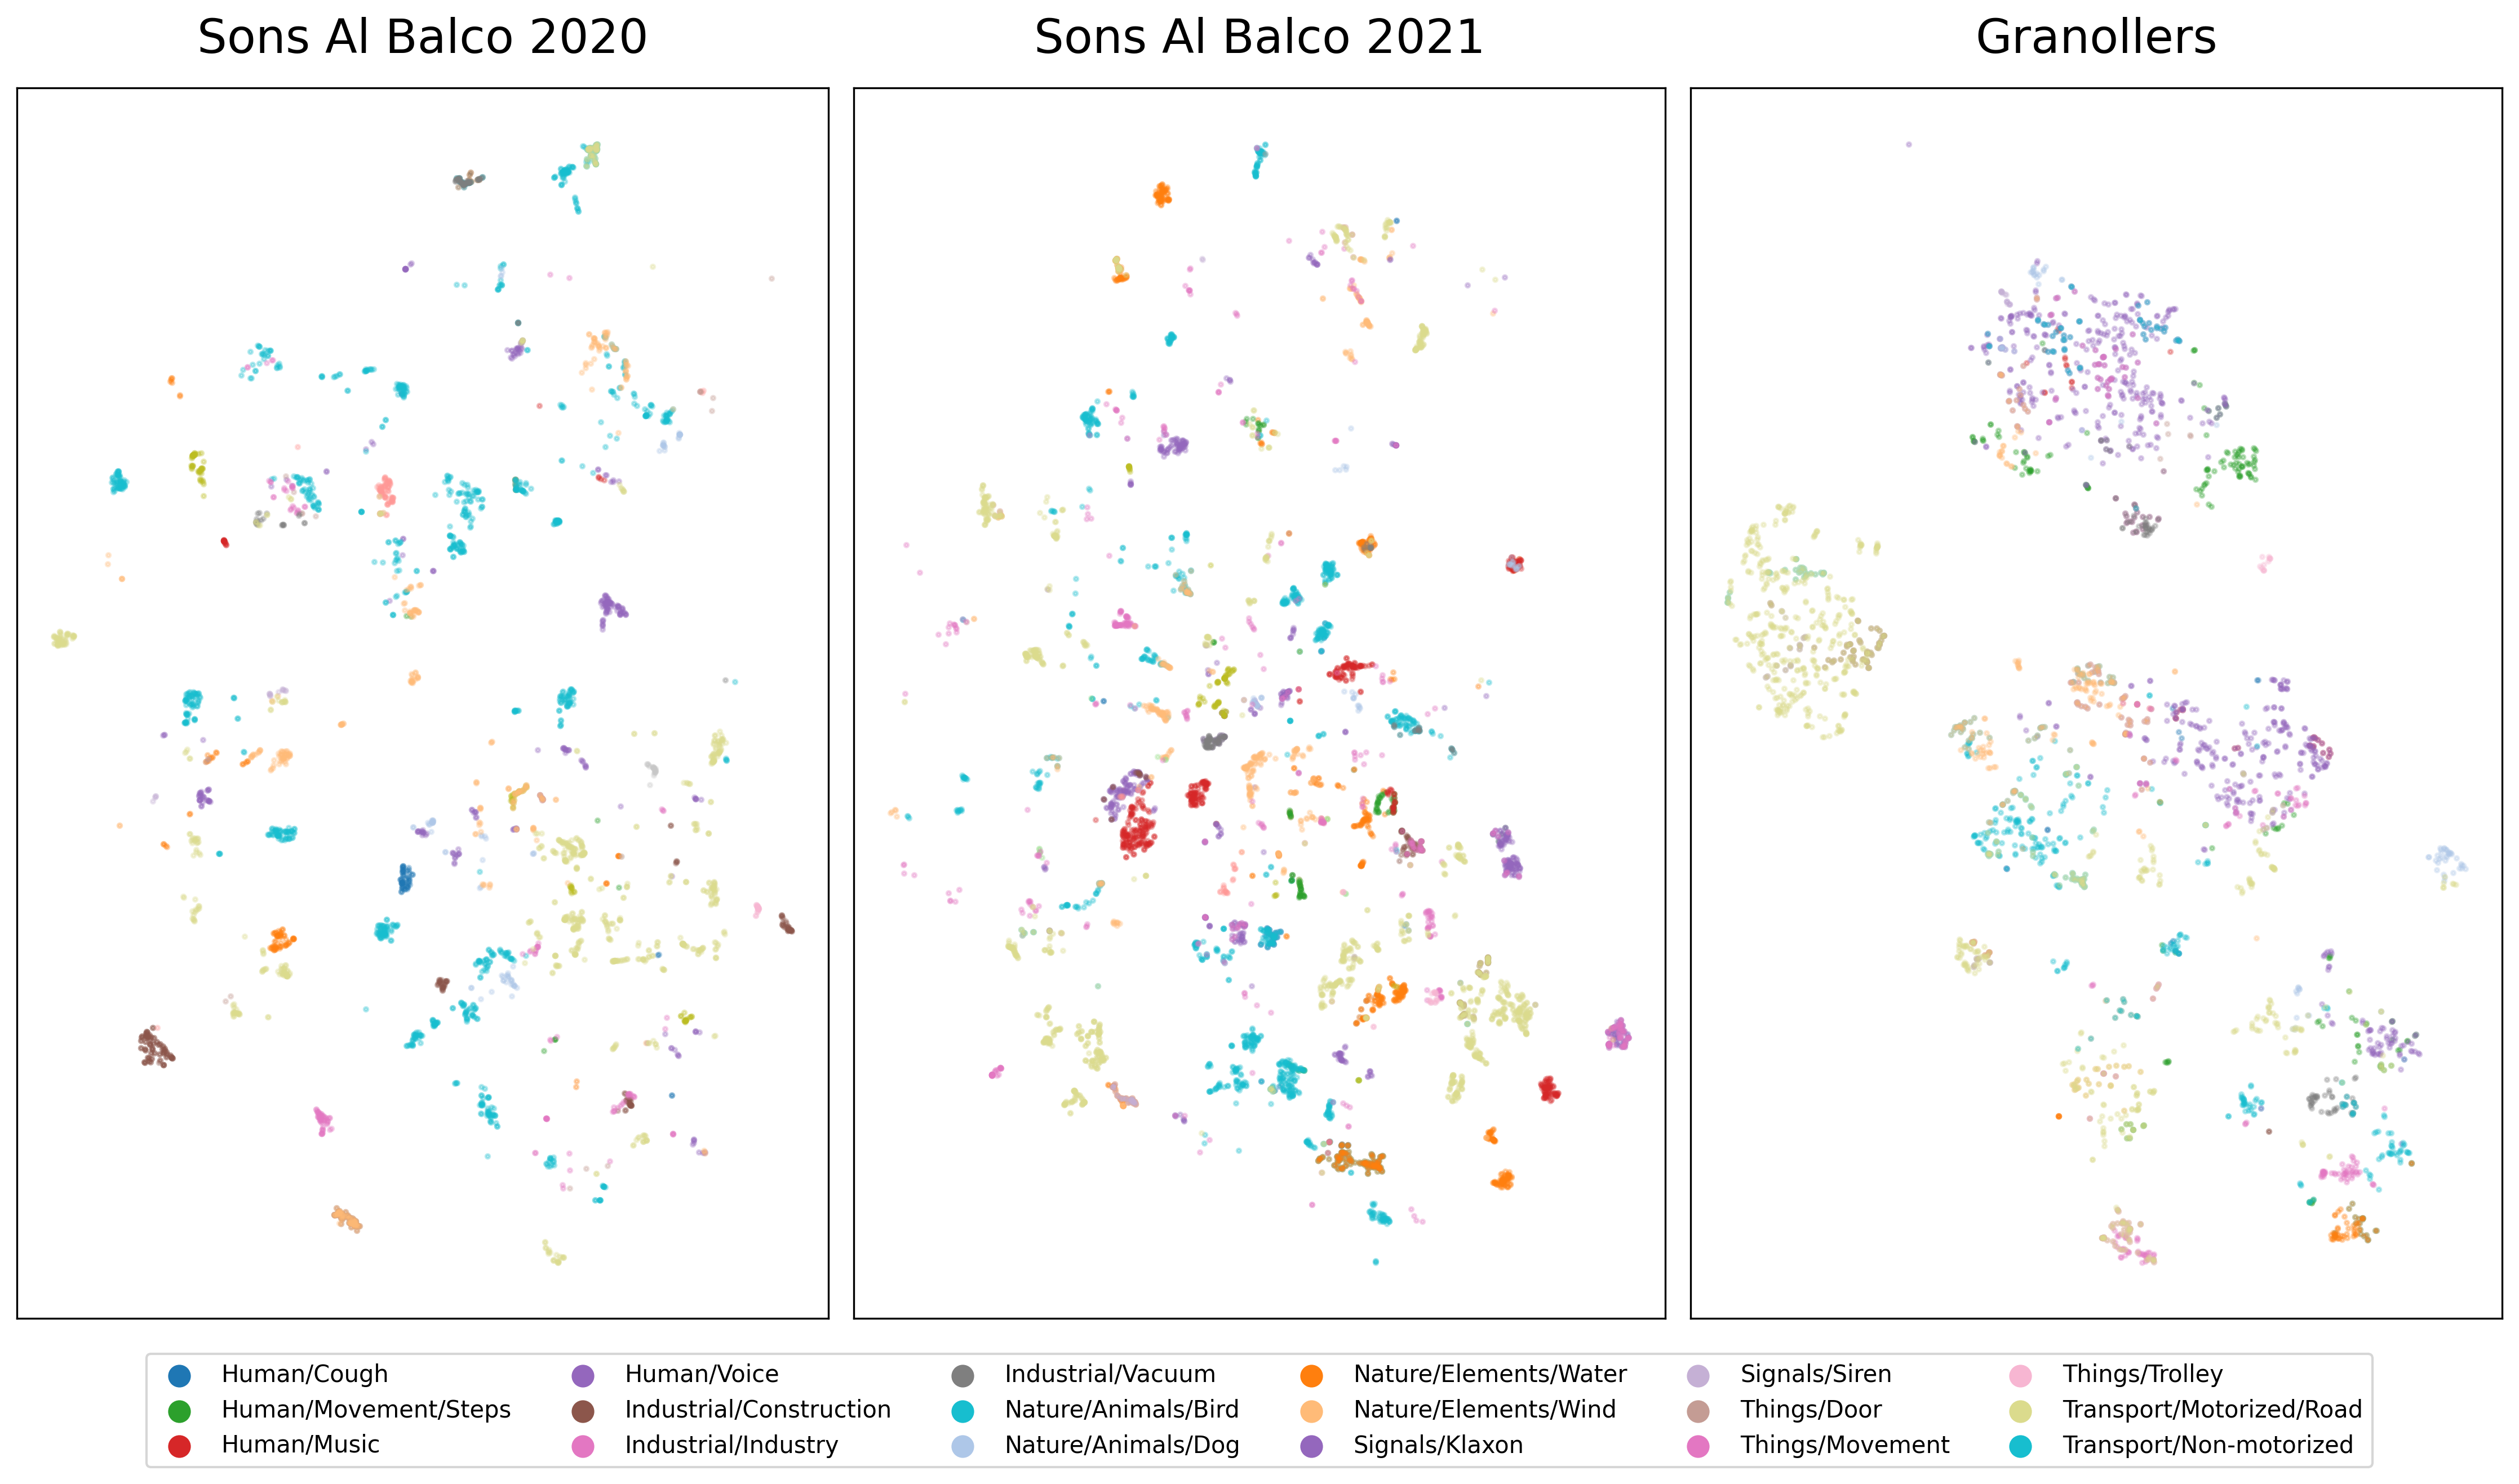

In [23]:
plot_overall_embeddings(
        tsne_data, model_labels, idxs, datasets, all_labels, "tsne", image_folder
    )

In [5]:
all_labels

['Human/Cough',
 'Human/Movement',
 'Human/Movement/Steps',
 'Human/Music',
 'Human/Voice',
 'Industrial/Construction',
 'Industrial/Industry',
 'Industrial/Vacuum',
 'Industrial/Ventilation',
 'Nature/Animals/Bird',
 'Nature/Animals/Cat',
 'Nature/Animals/Dog',
 'Nature/Elements/Water',
 'Nature/Elements/Wind',
 'Nature/Vegetation',
 'Signals',
 'Signals/Alarm',
 'Signals/Bells',
 'Signals/Klaxon',
 'Signals/Siren',
 'Things/Blind',
 'Things/Door',
 'Things/Movement',
 'Things/Trolley',
 'Transport/Motorized',
 'Transport/Motorized/Air',
 'Transport/Motorized/Rail',
 'Transport/Motorized/Road',
 'Transport/Non-motorized']